**Section 5A** <br>
2/4/25

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.animation as animation
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.spatial import ConvexHull

# Task 1: Density of States

**Part a) Density of States**

Hamiltonian for classical particle in a 2D harmonic oscillator potential: <br>
$H = \frac{p_x^2+p_y^2}{2m} + \frac{1}{2}m \omega^2 (x^2+y^2) = E$

Phase space volume: <br>
$\Omega(E) = \int \int \int \delta(E-H) dxdy dp_x dp_y$

Hypersphere volume: <br>
$\Omega(E) = \frac{\pi^2}{2}(2mE)^2$

Density of states: <br>
$g(E) = \frac{d\Omega(E)}{dE} = 4\pi^2m^2E$

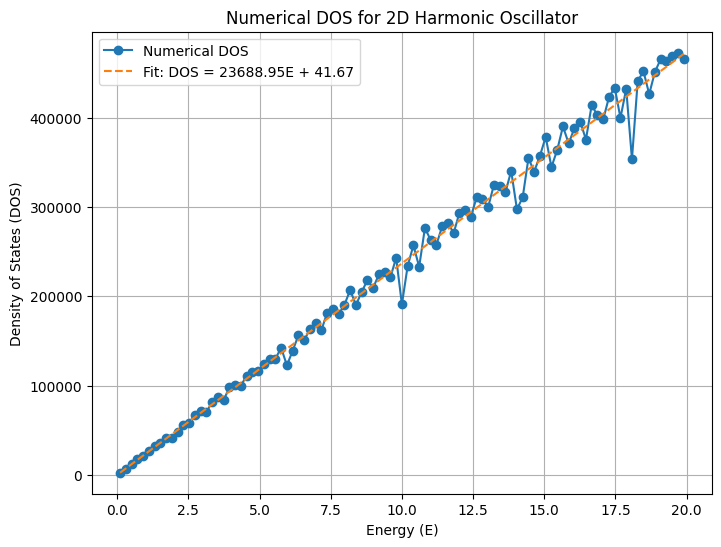

In [2]:
# now solve numerically

# Constants
m = 1.0  # Mass of the particle
omega = 1.0  # Angular frequency of the harmonic oscillator

# Phase space grid resolution
x_range = np.linspace(-10, 10, 100)
y_range = np.linspace(-10, 10, 100)
px_range = np.linspace(-10, 10, 100)
py_range = np.linspace(-10, 10, 100)

# Create mesh grid for x, y, p_x, p_y
x, y, px, py = np.meshgrid(x_range, y_range, px_range, py_range, indexing="ij")

# Hamiltonian: H = (p_x^2 + p_y^2)/(2m) + 1/2 * m * omega^2 * (x^2 + y^2)
energy = (px**2 + py**2) / (2 * m) + 0.5 * m * omega**2 * (x**2 + y**2)

# Flatten the energy array
energy_flat = energy.ravel()

# Define energy bins
num_bins = 100
energy_bins = np.linspace(0, 20, num_bins)
dos = []

# Calculate the DOS: Count states in each energy bin
delta_e = energy_bins[1] - energy_bins[0]
for i in range(len(energy_bins) - 1):
    e_min, e_max = energy_bins[i], energy_bins[i + 1]
    count = np.sum((energy_flat >= e_min) & (energy_flat < e_max))
    dos.append(count / delta_e)  # Normalize by energy width

dos = np.array(dos)

# Fit the DOS using a polynomial least-square approach
def polynomial_fit(E, a, b):
    return a * E + b

energy_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
params, _ = curve_fit(polynomial_fit, energy_centers, dos)

# Plot the DOS
plt.figure(figsize=(8, 6))
plt.plot(energy_centers, dos, label="Numerical DOS", marker="o")
plt.plot(energy_centers, polynomial_fit(energy_centers, *params), label=f"Fit: DOS = {params[0]:.2f}E + {params[1]:.2f}", linestyle="--")
plt.xlabel("Energy (E)")
plt.ylabel("Density of States (DOS)")
plt.title("Numerical DOS for 2D Harmonic Oscillator")
plt.legend()
plt.grid()
plt.show()

**Part b) Partition Function via Density of States**

Canonical partition function: <br>
$Z(\beta) = \int_{0}^{\infty} g(E) e^{-\beta E} dE$ <br>
where $\beta = \frac{1}{kT}$

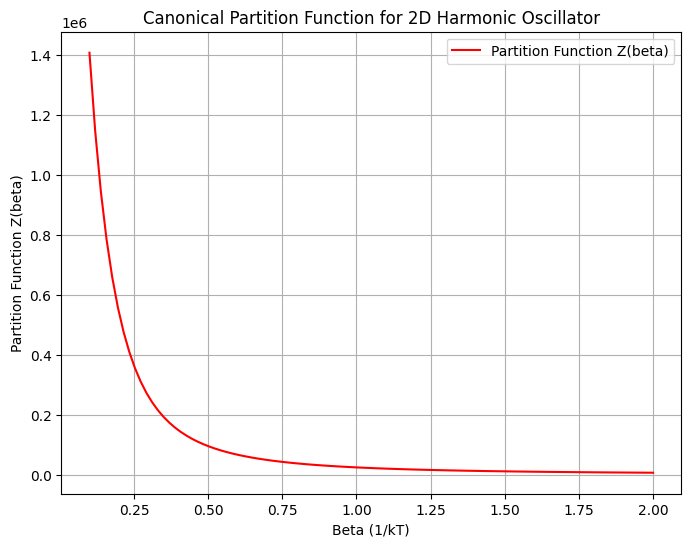

In [5]:
# approximate the integral by taking summation with discrete energy bins

# Canonical partition function Z(beta)
def partition_function(beta, energy, dos):
    Z = np.sum(dos * np.exp(-beta * energy) * delta_e)
    return Z

# Calculate Z(beta) for a range of beta values
beta_values = np.linspace(0.1, 2.0, 100)
Z_values = [partition_function(beta, energy_centers, dos) for beta in beta_values]

# Plot Z(beta)
plt.figure(figsize=(8, 6))
plt.plot(beta_values, Z_values, label="Partition Function Z(beta)", color="r")
plt.xlabel("Beta (1/kT)")
plt.ylabel("Partition Function Z(beta)")
plt.title("Canonical Partition Function for 2D Harmonic Oscillator")
plt.legend()
plt.grid()
plt.show()

**Part c) Density of States of 2D non-linear harmonic oscillator potential**

New Hamiltonian: <br>
$H = \frac{p_x^2+p_y^2}{2m} + \frac{1}{2}m\omega^2(x^2+y^2) + \lambda(x^2+y^2)^2$

$g(E) = \frac{1}{(2\pi \hbar)^2}\int \delta(H-E) dxdydp_xdp_y$

$g(E) = \frac{4\pi^2}{(2\pi\hbar)^2} \int_0^{\sqrt{\frac{-\frac{1}{2}m\omega^2 + \sqrt{\left(\frac{1}{2}m\omega^2\right)^2 + 4\lambda E}}{2\lambda}}} 
r \sqrt{2m\left(E - \frac{1}{2}m\omega^2 r^2 - \lambda r^4\right)} \, dr
$


# Task 2: Double Pendulum Dynamics

**Part a) Lagrangian**

Define origin at the center of the pendulum, with x increasing to the right and y increasing upwards. <br>
$x_1 = L_1 \sin{\theta_1}$ <br>
$y_1 = -L_1 \cos{\theta_1}$ <br>
$x_2 = x_1 + L_2 \sin{\theta_2}$ <br>
$y_2 = y_1 -L_2 \cos{\theta_2}$ <br>

$x_1' = \theta_1' L_1 \cos{\theta_1}$ <br>
$y_1' = \theta_1' L_1 \sin{\theta_1}$ <br>
$x_2' = x_1' + \theta_2' L_2 \cos{\theta_2}$ <br>
$y_1' = y_1' + \theta_2' L_2 \sin{\theta_2}$ <br>

Lagrangian: $L = T - U$ <br>
Kinetic energy: $T = \frac{1}{2}m_1(x_1'^2+y_1'^2)+\frac{1}{2}m_2(x_2'^2+y_2'^2)$ <br>
Potential energy: $U = -m_1gL_1\cos{\theta_1} - m_2g(L_1\cos{\theta_1}+L_2\cos{\theta_2})$

Equations of motion in matrix form, in terms of $\theta_1$ and $\theta_2$:

$$
\begin{bmatrix}
(m_1 + m_2) l_1^2 & m_2 l_1 l_2 \cos(\theta_1 - \theta_2) \\
m_2 l_1 l_2 \cos(\theta_1 - \theta_2) & m_2 l_2^2
\end{bmatrix}

\begin{bmatrix}
\ddot{\theta}_1 \\
\ddot{\theta}_2
\end{bmatrix}
=
\begin{bmatrix}
-m_2 l_1 l_2 \dot{\theta}_2^2 \sin(\theta_1 - \theta_2) - (m_1 + m_2) g l_1 \sin(\theta_1) \\
m_2 l_1 l_2 \dot{\theta}_1^2 \sin(\theta_1 - \theta_2) - m_2 g l_2 \sin(\theta_2)
\end{bmatrix}
$$

Lagrangian:

$$
L = \frac{1}{2} m_1 L_1^2 \dot{\theta}_1^2 + \frac{1}{2} m_2 \left( L_1^2 \dot{\theta}_1^2 + L_2^2 \dot{\theta}_2^2 + 2 L_1 L_2 \dot{\theta}_1 \dot{\theta}_2 \cos(\theta_1 - \theta_2) \right)
- m_1 g L_1 \cos(\theta_1) - m_2 g \left( L_1 \cos(\theta_1) + L_2 \cos(\theta_2) \right)
$$

**Part b) Hamiltonian**

Hamiltonian: <br>
$H(q, p, t) = p \dot{q} - L(q, \dot{q}, t)$

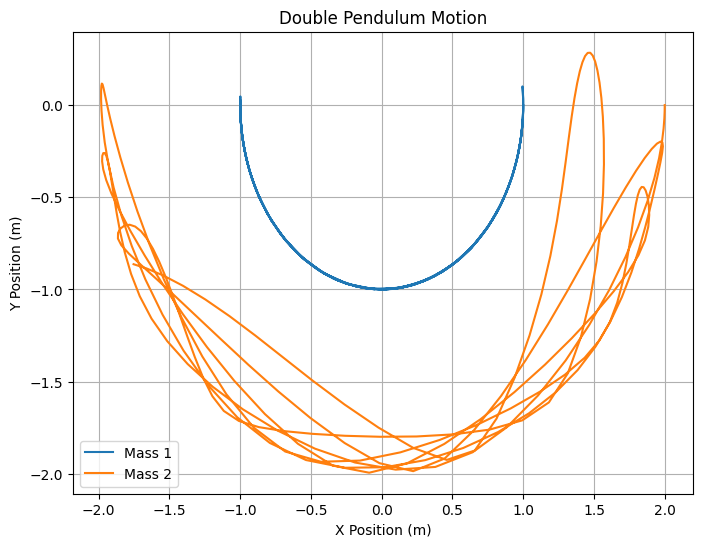

In [2]:
# Constants
m1 = 1.0  # mass of the first pendulum
m2 = 1.0  # mass of the second pendulum
l1 = 1.0  # length of the first pendulum
l2 = 1.0  # length of the second pendulum
g = 9.81  # acceleration due to gravity

# Equations of motion for the double pendulum
def equations(y, t):
    theta1, theta2, omega1, omega2 = y

    # Equations derived from the Lagrangian
    delta_theta = theta2 - theta1

    denom1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta_theta) ** 2
    denom2 = (l2 / l1) * denom1

    dtheta1_dt = omega1
    dtheta2_dt = omega2

    domega1_dt = (m2 * l2 * omega2 ** 2 * np.sin(delta_theta) * np.cos(delta_theta) 
                  + m2 * g * np.sin(theta2) * np.cos(delta_theta)
                  + m2 * l2 * omega2 ** 2 * np.sin(delta_theta) 
                  - (m1 + m2) * g * np.sin(theta1)) / denom1

    domega2_dt = (-m2 * l2 * omega2 ** 2 * np.sin(delta_theta) * np.cos(delta_theta)
                  + (m1 + m2) * g * np.sin(theta1) * np.cos(delta_theta)
                  - (m1 + m2) * l1 * omega1 ** 2 * np.sin(delta_theta)
                  - (m1 + m2) * g * np.sin(theta2)) / denom2

    return [dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt]

# Initial conditions: [theta1, theta2, omega1, omega2]
initial_conditions = [np.pi / 2, np.pi / 2, 0.0, 0.0]

# Time points where the solution is computed
t = np.linspace(0, 10, 250)

# Solve the ODEs
solution = odeint(equations, initial_conditions, t)

# Extract the angles from the solution
theta1 = solution[:, 0]
theta2 = solution[:, 1]

# Convert the polar coordinates to Cartesian for plotting
x1 = l1 * np.sin(theta1)
y1 = -l1 * np.cos(theta1)
x2 = l1 * np.sin(theta1) + l2 * np.sin(theta2)
y2 = -l1 * np.cos(theta1) - l2 * np.cos(theta2)

# Plot the motion
plt.figure(figsize=(8, 6))
plt.plot(x1, y1, label="Mass 1")
plt.plot(x2, y2, label="Mass 2")
plt.title("Double Pendulum Motion")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid()
plt.show()

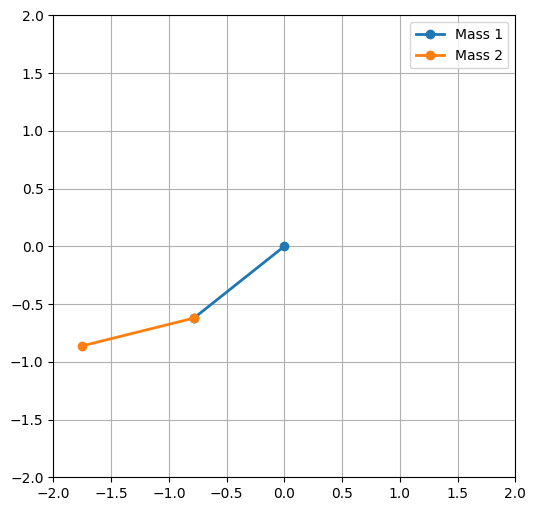

In [3]:
# Constants
m1 = 1.0  # mass of the first pendulum
m2 = 1.0  # mass of the second pendulum
l1 = 1.0  # length of the first pendulum
l2 = 1.0  # length of the second pendulum
g = 9.81  # acceleration due to gravity

# Equations of motion for the double pendulum
def equations(y, t):
    theta1, theta2, omega1, omega2 = y

    # Equations derived from the Lagrangian
    delta_theta = theta2 - theta1

    denom1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta_theta) ** 2
    denom2 = (l2 / l1) * denom1

    dtheta1_dt = omega1
    dtheta2_dt = omega2

    domega1_dt = (m2 * l2 * omega2 ** 2 * np.sin(delta_theta) * np.cos(delta_theta) 
                  + m2 * g * np.sin(theta2) * np.cos(delta_theta)
                  + m2 * l2 * omega2 ** 2 * np.sin(delta_theta) 
                  - (m1 + m2) * g * np.sin(theta1)) / denom1

    domega2_dt = (-m2 * l2 * omega2 ** 2 * np.sin(delta_theta) * np.cos(delta_theta)
                  + (m1 + m2) * g * np.sin(theta1) * np.cos(delta_theta)
                  - (m1 + m2) * l1 * omega1 ** 2 * np.sin(delta_theta)
                  - (m1 + m2) * g * np.sin(theta2)) / denom2

    return [dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt]

# Initial conditions: [theta1, theta2, omega1, omega2]
initial_conditions = [np.pi / 2, np.pi / 2, 0.0, 0.0]

# Time points where the solution is computed
t = np.linspace(0, 10, 250)

# Solve the ODEs
solution = odeint(equations, initial_conditions, t)

# Extract the angles from the solution
theta1 = solution[:, 0]
theta2 = solution[:, 1]

# Convert the polar coordinates to Cartesian for plotting
x1 = l1 * np.sin(theta1)
y1 = -l1 * np.cos(theta1)
x2 = l1 * np.sin(theta1) + l2 * np.sin(theta2)
y2 = -l1 * np.cos(theta1) - l2 * np.cos(theta2)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid(True)

# Create lines for the pendulums
line1, = ax.plot([], [], 'o-', lw=2, label="Mass 1")
line2, = ax.plot([], [], 'o-', lw=2, label="Mass 2")
ax.legend()

# Initialize the plot elements
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

# Update function for the animation
def update(frame):
    line1.set_data([0, x1[frame]], [0, y1[frame]])
    line2.set_data([x1[frame], x2[frame]], [y1[frame], y2[frame]])
    return line1, line2

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True)

# Save the animation as a video
ani.save('double_pendulum_motion.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

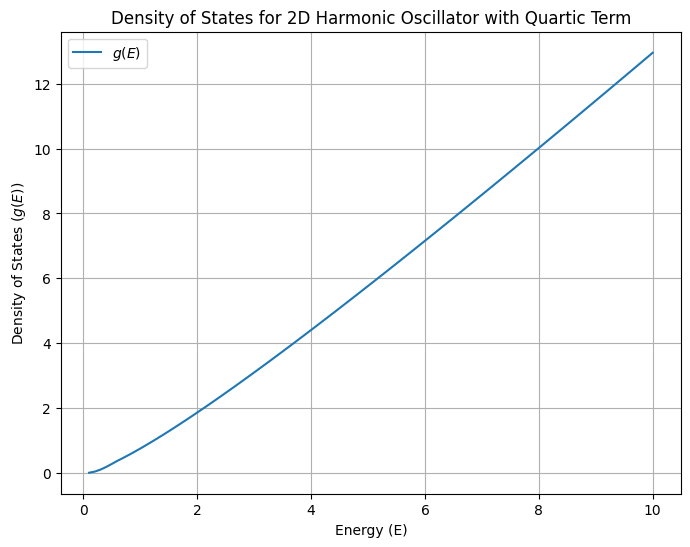

In [4]:
# Constants
hbar = 1 #1.0545718e-34  # Planck's constant (Joule-second)
m = 1.0               # Mass of the particle (arbitrary units)
omega = 1.0          # Harmonic oscillator frequency (arbitrary units)
lmbda = 0.1          # Quartic potential coefficient (arbitrary units)

# Energy range to evaluate DOS
def calc_rmax(E):
    """Solve for r_max where E = (1/2)m*omega^2*r^2 + lambda*r^4"""
    coeffs = [lmbda, 0, 0.5 * m * omega**2, -E]  # Coefficients of r^4 + (1/2)m*omega^2*r^2 - E = 0
    roots = np.roots(coeffs)                    # Solve the quartic equation
    real_roots = [r.real for r in roots if r.imag == 0 and r.real >= 0]  # Keep only positive real roots
    return max(real_roots) if real_roots else 0

def integrand(r, E):
    """The integrand for g(E): r * sqrt(2m(E - (1/2)m*omega^2*r^2 - lambda*r^4))"""
    potential = 0.5 * m * omega**2 * r**2 + lmbda * r**4
    kinetic = E - potential
    if kinetic < 0:
        return 0
    return r * np.sqrt(2 * m * kinetic)

def density_of_states(E):
    """Compute g(E) numerically."""
    r_max = calc_rmax(E)  # Find the maximum radial distance for the given energy
    if r_max == 0:
        return 0

    # Integrate over r from 0 to r_max
    integral, _ = quad(integrand, 0, r_max, args=(E,))
    
    # Multiply by the prefactor
    prefactor = 4 * np.pi**2 / (2 * np.pi * hbar)**2
    return prefactor * integral

# Evaluate DOS for a range of energies
E_values = np.linspace(0.1, 10, 100)  # Energy values (arbitrary range)
g_values = [density_of_states(E) for E in E_values]

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(E_values, g_values, label="$g(E)$")
plt.xlabel("Energy (E)")
plt.ylabel("Density of States ($g(E)$)")
plt.title("Density of States for 2D Harmonic Oscillator with Quartic Term")
plt.legend()
plt.grid()
plt.show()

**Part c) Hamiltonian and Phase space dynamics**

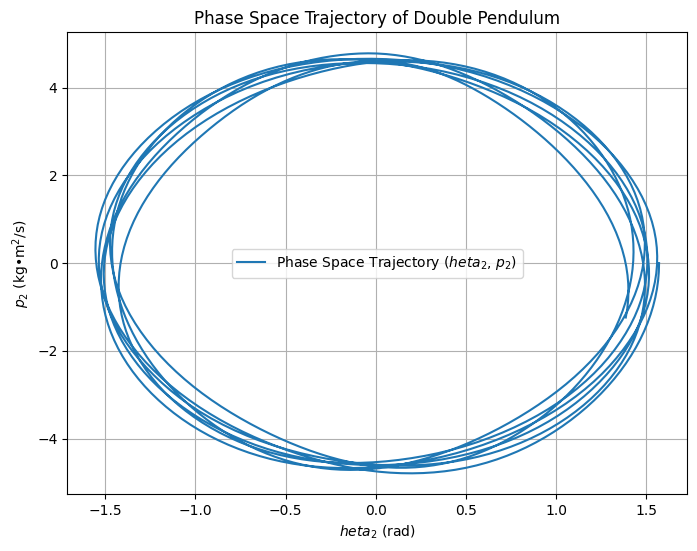

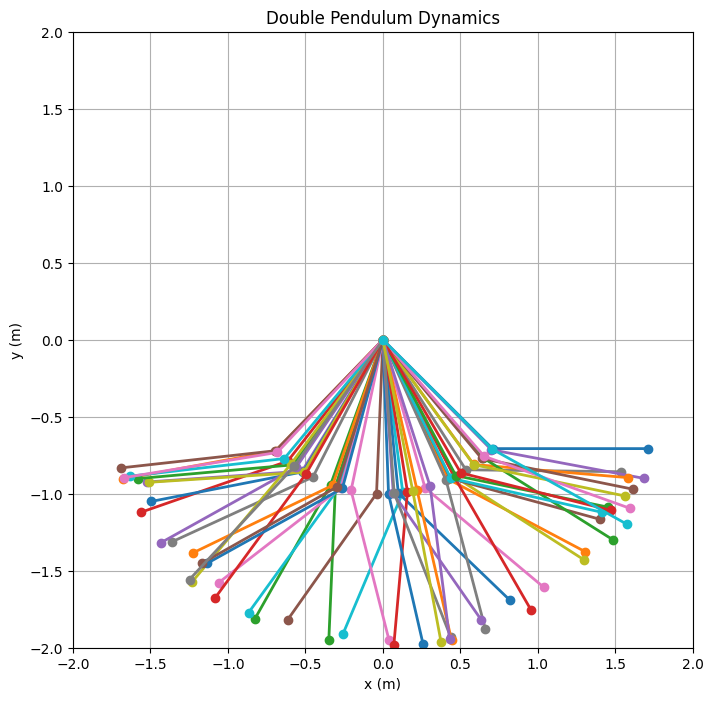

In [6]:
# Constants
g = 9.81  # Gravitational acceleration (m/s^2)
m1, m2 = 1.0, 1.0  # Masses of the pendulums (kg)
l1, l2 = 1.0, 1.0  # Lengths of the pendulums (m)

# Equations of motion
def double_pendulum(t, y):
    """Compute derivatives for the double pendulum system."""
    theta1, theta2, p1, p2 = y

    # Common terms
    delta = theta2 - theta1
    denom1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta)**2
    denom2 = (l2 / l1) * denom1

    # Derivatives
    dtheta1 = (l2 * p1 - l1 * p2 * np.cos(delta)) / (l1 * l2 * denom1)
    dtheta2 = ((m1 + m2) * l1 * p2 - m2 * l2 * p1 * np.cos(delta)) / (m2 * l1 * l2 * denom1)

    dp1 = -(m1 + m2) * g * l1 * np.sin(theta1) - dtheta1 * dtheta2 * np.sin(delta) * l1 * l2 * m2 / denom1
    dp2 = -m2 * g * l2 * np.sin(theta2) + dtheta1 * dtheta2 * np.sin(delta) * l1 * l2 * m2 / denom2

    return [dtheta1, dtheta2, dp1, dp2]

# Initial conditions (angles in radians, momenta)
initial_conditions = [np.pi / 4, np.pi / 2, 0, 0]  # [theta1, theta2, p1, p2]
time_span = (0, 20)  # Time range for simulation (s)
t_eval = np.linspace(time_span[0], time_span[1], 1000)  # Time points for output

# Solve the system
def solve_double_pendulum():
    solution = solve_ivp(double_pendulum, time_span, initial_conditions, t_eval=t_eval, method='RK45')
    return solution

solution = solve_double_pendulum()

# Extract solutions
theta1, theta2 = solution.y[0], solution.y[1]
p1, p2 = solution.y[2], solution.y[3]

# Convert to Cartesian coordinates for visualization
x1 = l1 * np.sin(theta1)
y1 = -l1 * np.cos(theta1)
x2 = x1 + l2 * np.sin(theta2)
y2 = y1 - l2 * np.cos(theta2)

# Plot phase space trajectory (theta2, p2)
plt.figure(figsize=(8, 6))
plt.plot(theta2, p2, label="Phase Space Trajectory ($\theta_2$, $p_2$)")
plt.xlabel("$\theta_2$ (rad)")
plt.ylabel("$p_2$ (kg\u2022m$^2$/s)")
plt.title("Phase Space Trajectory of Double Pendulum")
plt.legend()
plt.grid()
plt.show()

# Plot double pendulum dynamics in real space
plt.figure(figsize=(8, 8))
for i in range(0, len(t_eval), 20):  # Plot every 20th frame for clarity
    plt.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], 'o-', lw=2)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("Double Pendulum Dynamics")
plt.grid()
plt.show()

**Part d) Phase space density**

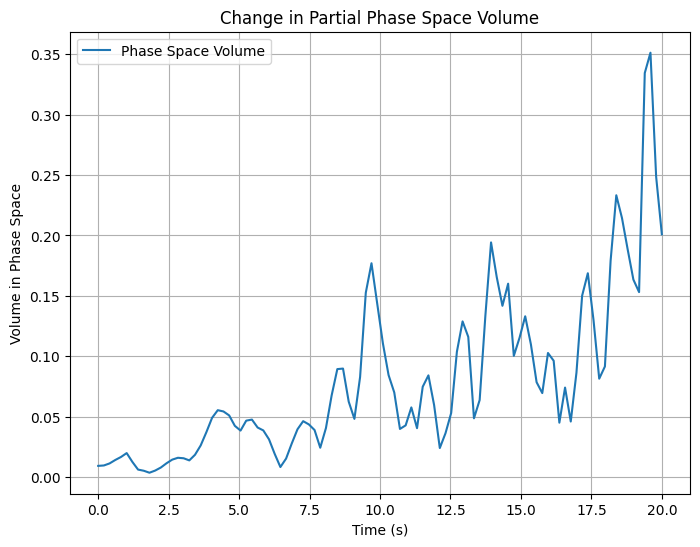

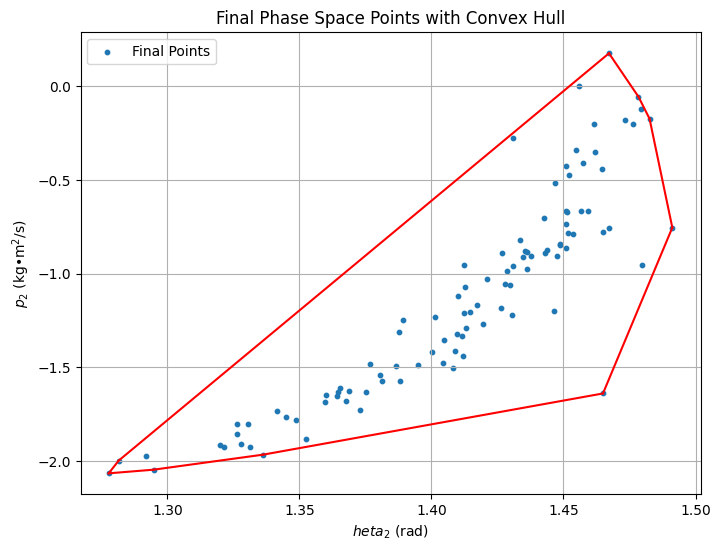

In [8]:
# Constants
g = 9.81  # Gravitational acceleration (m/s^2)
m1, m2 = 1.0, 1.0  # Masses of the pendulums (kg)
l1, l2 = 1.0, 1.0  # Lengths of the pendulums (m)

# Equations of motion
def double_pendulum(t, y):
    """Compute derivatives for the double pendulum system."""
    theta1, theta2, p1, p2 = y

    # Common terms
    delta = theta2 - theta1
    denom1 = (m1 + m2) * l1 - m2 * l1 * np.cos(delta)**2
    denom2 = (l2 / l1) * denom1

    # Derivatives
    dtheta1 = (l2 * p1 - l1 * p2 * np.cos(delta)) / (l1 * l2 * denom1)
    dtheta2 = ((m1 + m2) * l1 * p2 - m2 * l2 * p1 * np.cos(delta)) / (m2 * l1 * l2 * denom1)

    dp1 = -(m1 + m2) * g * l1 * np.sin(theta1) - dtheta1 * dtheta2 * np.sin(delta) * l1 * l2 * m2 / denom1
    dp2 = -m2 * g * l2 * np.sin(theta2) + dtheta1 * dtheta2 * np.sin(delta) * l1 * l2 * m2 / denom2

    return [dtheta1, dtheta2, dp1, dp2]

# Initialize a point cloud around initial conditions
def initialize_point_cloud(initial_conditions, n_points, spread):
    """Generate a cloud of initial conditions around a central point."""
    point_cloud = []
    for _ in range(n_points):
        perturbation = np.random.uniform(-spread, spread, size=4)
        point_cloud.append(initial_conditions + perturbation)
    return np.array(point_cloud)

# Solve for each point in the point cloud
def solve_point_cloud(point_cloud, time_span, t_eval):
    """Solve the equations of motion for each point in the cloud."""
    trajectories = []
    for point in point_cloud:
        solution = solve_ivp(double_pendulum, time_span, point, t_eval=t_eval, method='RK45')
        trajectories.append(solution.y)
    return np.array(trajectories)

# Compute convex hull volume
def compute_convex_hull_volume(phase_space_points):
    """Calculate the volume of the convex hull in (theta2, p2) space."""
    hull = ConvexHull(phase_space_points)
    return hull.volume

# Initial conditions and parameters
initial_conditions = [np.pi / 4, np.pi / 2, 0, 0]  # [theta1, theta2, p1, p2]
n_points = 100  # Number of points in the cloud
spread = 0.05  # Spread of initial conditions
time_span = (0, 20)  # Time range for simulation (s)
t_eval = np.linspace(time_span[0], time_span[1], 100)  # Time points for output

# Initialize point cloud
point_cloud = initialize_point_cloud(initial_conditions, n_points, spread)

# Solve trajectories
trajectories = solve_point_cloud(point_cloud, time_span, t_eval)

# Analyze phase space volumes over time
volumes = []
for i in range(len(t_eval)):
    phase_space_points = np.column_stack((trajectories[:, 1, i], trajectories[:, 3, i]))  # (theta2, p2)
    volume = compute_convex_hull_volume(phase_space_points)
    volumes.append(volume)

# Plot change in phase space volume
plt.figure(figsize=(8, 6))
plt.plot(t_eval, volumes, label="Phase Space Volume")
plt.xlabel("Time (s)")
plt.ylabel("Volume in Phase Space")
plt.title("Change in Partial Phase Space Volume")
plt.legend()
plt.grid()
plt.show()

# Final phase space trajectory (theta2, p2) cloud and convex hull
final_phase_space_points = np.column_stack((trajectories[:, 1, -1], trajectories[:, 3, -1]))
final_hull = ConvexHull(final_phase_space_points)

plt.figure(figsize=(8, 6))
plt.scatter(final_phase_space_points[:, 0], final_phase_space_points[:, 1], label="Final Points", s=10)
for simplex in final_hull.simplices:
    plt.plot(final_phase_space_points[simplex, 0], final_phase_space_points[simplex, 1], 'r-')
plt.xlabel("$\theta_2$ (rad)")
plt.ylabel("$p_2$ (kg\u2022m$^2$/s)")
plt.title("Final Phase Space Points with Convex Hull")
plt.legend()
plt.grid()
plt.show()